In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [3]:
!pip install pytorch-tabnet

  Using cached pytorch_tabnet-4.1.0-py3-none-any.whl.metadata (15 kB)
Using cached pytorch_tabnet-4.1.0-py3-none-any.whl (44 kB)


In [4]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import Pipeline


import tensorflow as tf
from tensorflow.keras import layers, models

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")

In [6]:
train_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [7]:
test_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [8]:
train_df.shape

(58645, 13)

In [9]:
test_df.shape

(39098, 12)

In [10]:
train_df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [11]:
train_df.describe(include='O')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,58645,58645,58645,58645
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,30594,12271,20984,49943


In [12]:
train_df.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [13]:
train_df.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

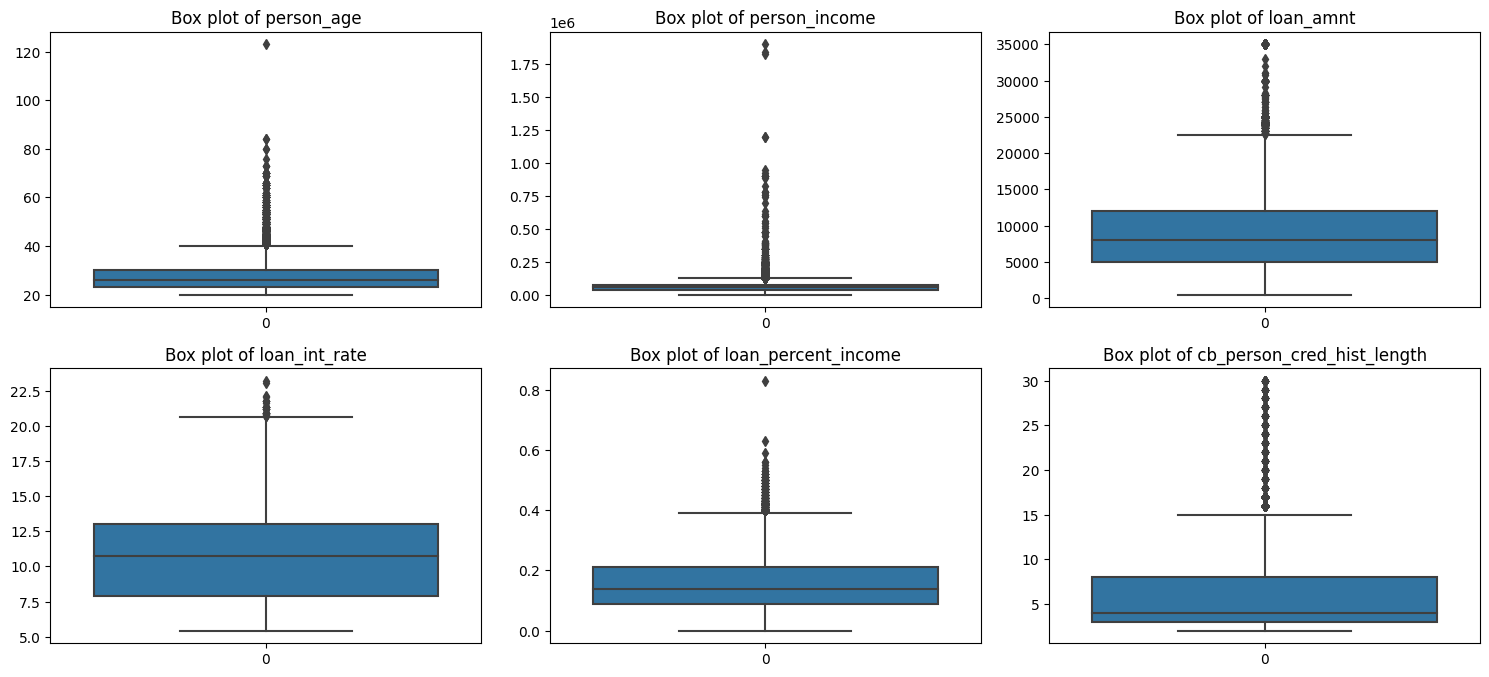

In [14]:
# List of numerical columns for which to check outliers
numerical_columns = ['person_age', 'person_income', 
                     'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
                     'cb_person_cred_hist_length']

# Display box plots for all numerical columns
plt.figure(figsize=(15,10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=train_df[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

In [15]:
# Function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from all numerical columns
for column in numerical_columns:
    train_df = remove_outliers(train_df, column)

print(train_df.shape)

(49443, 13)


In [16]:
train_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
5,5,27,45000,RENT,2.0,VENTURE,A,9000,8.94,0.20,N,5,0


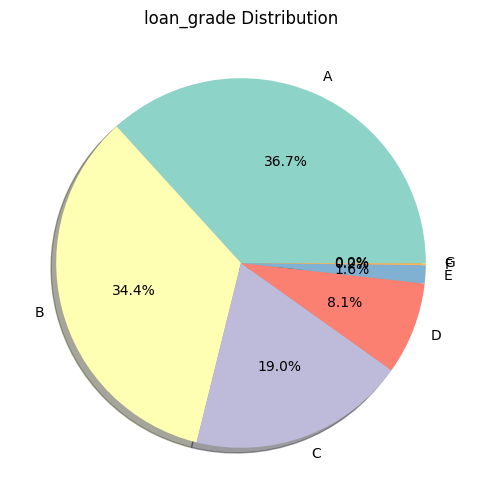

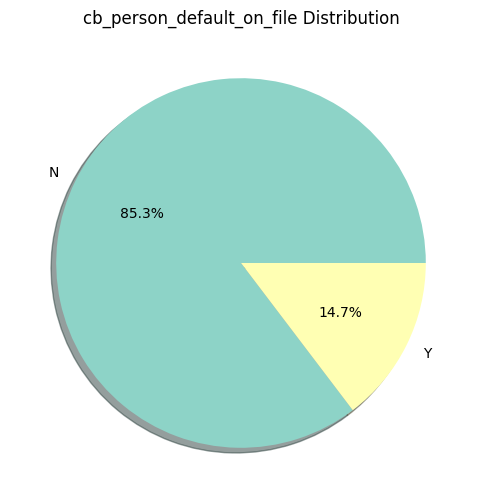

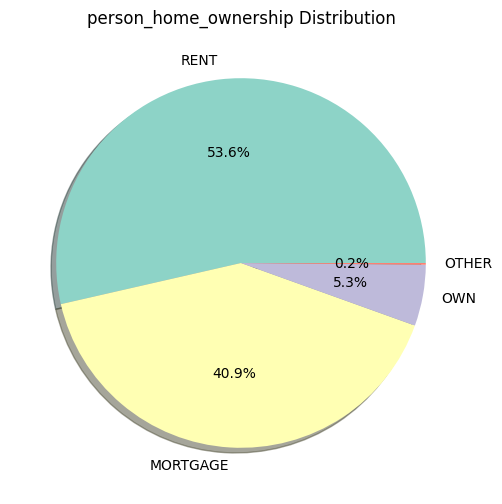

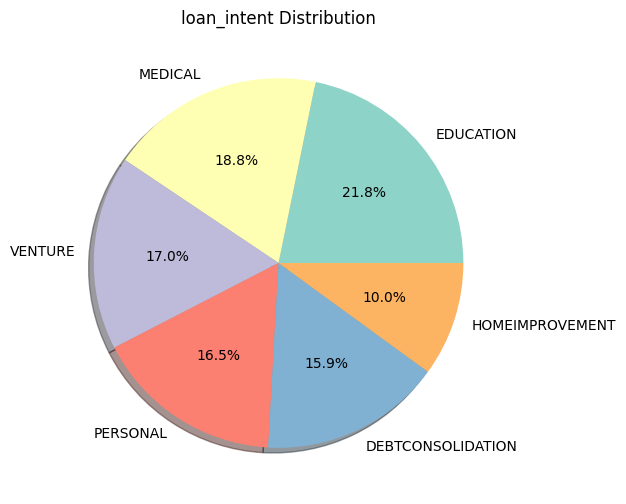

In [17]:
categorical_columns = ['loan_grade', 'cb_person_default_on_file', 'person_home_ownership', 'loan_intent']

for col in categorical_columns:
    
    # Pie chart for loan_status
    plt.figure(figsize=(6,6))
    train_df[col].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette("Set3"), shadow=True)

    # Add title
    plt.title(f"{col} Distribution")

    # Display the plot
    plt.ylabel('')  # Removes y-label for a cleaner look
    plt.show()


In [18]:
label_encoder = LabelEncoder()

train_df['loan_grade'] = label_encoder.fit_transform(train_df['loan_grade'])
test_df['loan_grade'] = label_encoder.fit_transform(test_df['loan_grade'])

In [19]:

# Training Dataset
# Columns to encode
unencoded_cols = ['cb_person_default_on_file', 'person_home_ownership', 'loan_intent']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the data
one_hot_encoded = encoder.fit_transform(train_df[unencoded_cols])

# Convert the NumPy array to a DataFrame
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(unencoded_cols))

# Concatenate the original DataFrame with the one-hot encoded DataFrame
new_df = pd.concat([train_df.reset_index(drop=True), one_hot_encoded_df.reset_index(drop=True)], axis=1)



# Testing Dataset
# Columns to encode
unencoded_cols = ['cb_person_default_on_file', 'person_home_ownership', 'loan_intent']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the data
one_hot_encoded = encoder.fit_transform(test_df[unencoded_cols])

# Convert the NumPy array to a DataFrame
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(unencoded_cols))

# Concatenate the original DataFrame with the one-hot encoded DataFrame
new_test_df = pd.concat([test_df.reset_index(drop=True), one_hot_encoded_df.reset_index(drop=True)], axis=1)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
new_df.columns
new_df.drop(columns=['cb_person_default_on_file', 'person_home_ownership', 'loan_intent'], inplace=True)
new_test_df.drop(columns=['cb_person_default_on_file', 'person_home_ownership', 'loan_intent'], inplace=True)

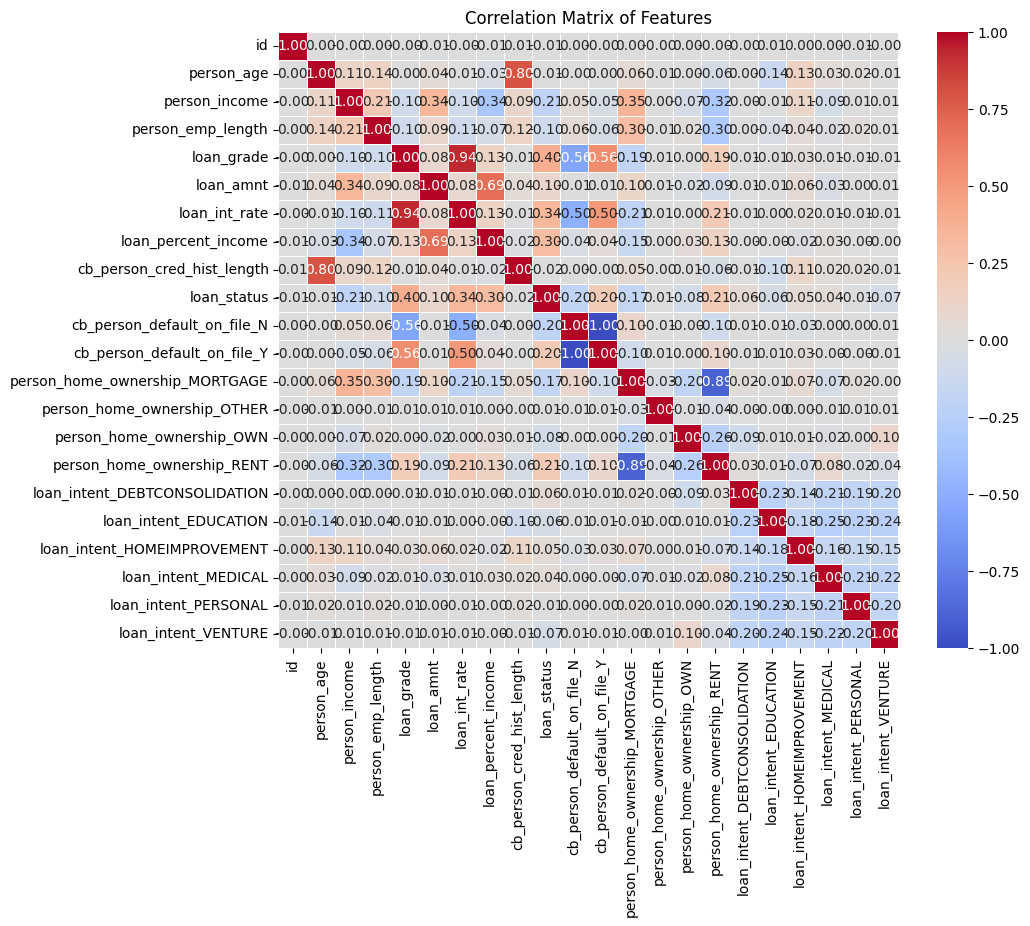

In [21]:
# Calculate the correlation matrix
correlation_matrix = new_df.corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add a title
plt.title('Correlation Matrix of Features')

# Show the plot
plt.show()

In [22]:
new_df.columns

Index(['id', 'person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'loan_status',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE'],
      dtype='object')

### **Training**

In [23]:
X = new_df[['person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE']]
y = new_df['loan_status']


X_t = new_test_df[['person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE']]

In [43]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X)

# Only transform the testing data (no fitting)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import lightgbm as lgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# Step 2: Handle Imbalance with SMOTE
smote = SMOTE(random_state=42)

# Step 3: Initialize Base Models for Stacking
# Using LightGBM and XGBoost as base models in the stacking ensemble
base_models = [
    ('lgb', lgb.LGBMClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Step 4: Initialize Meta-Classifier
# We can use LightGBM as the meta-classifier to learn from the combined base models' outputs
meta_classifier = lgb.LGBMClassifier(random_state=42)

# Step 5: Create the Stacking Pipeline using imblearn's Pipeline
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_classifier, cv=5)
pipeline = Pipeline([
    ('smote', smote),                # Apply SMOTE within the imblearn pipeline
    ('stacking', stacking_clf)       # Train the stacking classifier
])

# Step 6: Cross-Validation with StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv)

# Print Cross-Validation AUC Scores
print("AUC Scores for each fold: ", auc_scores)
print("Mean AUC Score from Cross-Validation: ", np.mean(auc_scores))

# Step 7: Train the Final Model on the Full Training Set
pipeline.fit(X_train, y_train)

# Step 8: Evaluate on the Test Set
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
print("Test Set AUC Score: ", roc_auc_score(y_test, y_pred_proba))

# Step 9: Additional Metrics for Evaluation
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 27575, number of negative: 27575
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4139
[LightGBM] [Info] Number of data points in the train set: 55150, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 22060, number of negative: 22060
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3960
[LightGBM] [Info] Number of data points in the train set: 44120, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

In [28]:
y_pred_pipline = pipeline.predict_proba(X_t)[:, 1]
y_pred_pipline

array([0.99081721, 0.01982778, 0.88756431, ..., 0.01785647, 0.28981374,
       0.99300274])

In [32]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import lightgbm as lgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)

# Define optimized base models using best parameters
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                          n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, random_state=42)
lgbm_model = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, device='gpu', random_state=42)

# Initialize Stacking Classifier with optimized base models
base_models = [
    ('xgb', xgb_model),
    ('lgb', lgbm_model)
]

# Set up LightGBM as the meta-classifier with optimized parameters
meta_classifier = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, device='gpu', random_state=42)

# Create stacking pipeline
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_classifier, cv=5)
pipeline = Pipeline([
    ('smote', smote),
    ('stacking', stacking_clf)
])

# Cross-validate and print AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv)
print("Cross-Validated AUC Scores:", auc_scores)
print("Mean AUC from Cross-Validation:", np.mean(auc_scores))

# Train final model on the full training set
pipeline.fit(X_train, y_train)

# Test set evaluation
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
print("Test Set AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Additional metrics
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 27575, number of negative: 27575
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4139
[LightGBM] [Info] Number of data points in the train set: 55150, number of used features: 20
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (0.63 MB) transferred to GPU in 0.001389 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [33]:
y_pred_pipline = pipeline.predict_proba(X_t)[:, 1]
y_pred_pipline

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([0.9927275 , 0.03820052, 0.39757799, ..., 0.04953848, 0.17056922,
       0.9886276 ])

In [23]:
# Initialize the Logistic Regression model
logst_model = LogisticRegression(max_iter=1000)

# Train the model
logst_model.fit(X_train, y_train)

# Make predictions
y_pred = logst_model.predict(X_test)
y_pred_proba = logst_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'AUC Score: {auc_score:.2f}')

Accuracy: 0.89
AUC Score: 0.83


In [24]:
# Initialize the XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
model.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'AUC Score: {auc_score:.2f}')

# # Make predictions
# y_pred = model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}')
# print(classification_report(y_test, y_pred))

AUC Score: 0.95


In [ ]:
# Using LightBGMClassifier

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
lgbm = LGBMClassifier(device='gpu')

# Define the parameter grid
lgbm_param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.01, 0.1, 0.002, 0.0125, 0.001],
    'max_depth': [3, 5, 7, 10, 15],
    'subsample': [0.8, 1.0]
}

# Apply Grid Search
lgbm_grid = GridSearchCV(estimator=lgbm, param_grid=lgbm_param_grid, scoring='accuracy', cv=5, verbose=1)
lgbm_grid.fit(X_train_scaled, y)

# Best parameters
print("Best LightGBM params: ", lgbm_grid.best_params_)


Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[LightGBM] [Info] Number of positive: 5062, number of negative: 34492
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 39554, number of used features: 20
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (0.45 MB) transferred to GPU in 0.001069 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127977 -> initscore=-1.918966
[LightGBM] [Info] Start training from score -1.918966
[LightGBM] [Info] Number of positive: 5062, number of negative: 34492
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 3955

In [45]:
# Best parameters
print("Best LightGBM params: ", lgbm_grid.best_params_)

Best LightGBM params:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150, 'subsample': 0.8}


In [46]:
lgbm_best = lgbm_grid.best_estimator_
lgbm_probs = lgbm_best.predict_proba(X_t)[:, 1]

lgbm_probs

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([0.05160869, 0.04138046, 0.20022724, ..., 0.01535444, 0.02722826,
       0.09179195])

In [39]:
# Calculate the AUC score
lgbm_auc_score = roc_auc_score(y_test, lgbm_probs)
print(f'AUC Score: {lgbm_auc_score:.2f}')

AUC Score: 0.95


In [27]:
yt_pred_proba = model.predict_proba(X_t)[:, 1]
yt_pred_proba

array([0.99885714, 0.00877564, 0.58106875, ..., 0.00354223, 0.0539941 ,
       0.9932433 ], dtype=float32)

In [48]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import numpy as np

# Check if GPU is available and set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the model without 'max_epochs' in the constructor
tabnet = TabNetClassifier(device_name=device)

# Define a focused parameter grid for faster tuning
tabnet_param_grid = {
    'n_d': [16],                # Reduced to a single value for faster grid search
    'n_a': [16],                # Reduced to a single value
    'n_steps': [3],             # Reduced to a single value for quick experimentation
    'gamma': [1.0, 1.5],        # Two values for fine-tuning
    'momentum': [0.02, 0.1]     # Two values for testing momentum effect
}

# Prepare the data (assuming your data is in pandas DataFrames)
X_train_tabnet = X_train.to_numpy()
y_train_tabnet = y_train.to_numpy()

# Wrap TabNet in a RandomizedSearchCV object for faster, random sampling
tabnet_random_search = RandomizedSearchCV(
    estimator=tabnet,
    param_distributions=tabnet_param_grid,
    scoring='accuracy',
    cv=3,                      # Reduced cross-validation folds
    n_iter=6,                  # Number of parameter settings sampled
    verbose=1
)

# Fit the model to the training data with max_epochs specified in the fit method
tabnet_random_search.fit(X_train_tabnet, y_train_tabnet, 
                         **{'max_epochs': 100})  # Specifying max_epochs in fit method

# Display the best parameters and score
print("Best Parameters:", tabnet_random_search.best_params_)
print("Best Accuracy Score:", tabnet_random_search.best_score_)


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=6. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
epoch 0  | loss: 0.34711 |  0:00:01s
epoch 1  | loss: 0.25962 |  0:00:02s
epoch 2  | loss: 0.23271 |  0:00:03s
epoch 3  | loss: 0.22197 |  0:00:04s
epoch 4  | loss: 0.21542 |  0:00:05s
epoch 5  | loss: 0.21145 |  0:00:06s
epoch 6  | loss: 0.20181 |  0:00:07s
epoch 7  | loss: 0.19917 |  0:00:08s
epoch 8  | loss: 0.19811 |  0:00:09s
epoch 9  | loss: 0.19416 |  0:00:10s
epoch 10 | loss: 0.19442 |  0:00:11s
epoch 11 | loss: 0.19086 |  0:00:12s
epoch 12 | loss: 0.18824 |  0:00:13s
epoch 13 | loss: 0.19018 |  0:00:14s
epoch 14 | loss: 0.18761 |  0:00:15s
epoch 15 | loss: 0.19568 |  0:00:16s
epoch 16 | loss: 0.19211 |  0:00:17s
epoch 17 | loss: 0.19112 |  0:00:18s
epoch 18 | loss: 0.18608 |  0:00:19s
epoch 19 | loss: 0.18617 |  0:00:20s
epoch 20 | loss: 0.18479 |  0:00:21s
epoch 21 | loss: 0.18549 |  0:00:22s
epoch 22 | loss: 0.18259 |  0:00:23s
epoch 23 | loss: 0.17928 |  0:00:24s
epoch 24 | loss: 0.18086 |  0:00:25s
epoch 25 | loss

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.34551 |  0:00:01s
epoch 1  | loss: 0.25408 |  0:00:02s
epoch 2  | loss: 0.23364 |  0:00:03s
epoch 3  | loss: 0.22533 |  0:00:04s
epoch 4  | loss: 0.21697 |  0:00:05s
epoch 5  | loss: 0.20895 |  0:00:06s
epoch 6  | loss: 0.2023  |  0:00:07s
epoch 7  | loss: 0.19959 |  0:00:08s
epoch 8  | loss: 0.19701 |  0:00:09s
epoch 9  | loss: 0.19216 |  0:00:10s
epoch 10 | loss: 0.19207 |  0:00:11s
epoch 11 | loss: 0.19319 |  0:00:12s
epoch 12 | loss: 0.19295 |  0:00:13s
epoch 13 | loss: 0.19916 |  0:00:14s
epoch 14 | loss: 0.19282 |  0:00:15s
epoch 15 | loss: 0.18845 |  0:00:16s
epoch 16 | loss: 0.18804 |  0:00:17s
epoch 17 | loss: 0.18782 |  0:00:18s
epoch 18 | loss: 0.18629 |  0:00:19s
epoch 19 | loss: 0.18285 |  0:00:20s
epoch 20 | loss: 0.18325 |  0:00:21s
epoch 21 | loss: 0.18392 |  0:00:22s
epoch 22 | loss: 0.18418 |  0:00:23s
epoch 23 | loss: 0.18126 |  0:00:25s
epoch 24 | loss: 0.18357 |  0:00:26s
epoch 25 | loss: 0.18314 |  0:00:27s
epoch 26 | loss: 0.18479 |  0:00:28s
e

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.35656 |  0:00:01s
epoch 1  | loss: 0.25141 |  0:00:02s
epoch 2  | loss: 0.23169 |  0:00:03s
epoch 3  | loss: 0.21812 |  0:00:04s
epoch 4  | loss: 0.20626 |  0:00:05s
epoch 5  | loss: 0.2048  |  0:00:06s
epoch 6  | loss: 0.20134 |  0:00:07s
epoch 7  | loss: 0.19857 |  0:00:08s
epoch 8  | loss: 0.19318 |  0:00:09s
epoch 9  | loss: 0.19429 |  0:00:10s
epoch 10 | loss: 0.19092 |  0:00:11s
epoch 11 | loss: 0.18661 |  0:00:12s
epoch 12 | loss: 0.185   |  0:00:13s
epoch 13 | loss: 0.18652 |  0:00:14s
epoch 14 | loss: 0.18501 |  0:00:15s
epoch 15 | loss: 0.18247 |  0:00:16s
epoch 16 | loss: 0.18108 |  0:00:17s
epoch 17 | loss: 0.18044 |  0:00:18s
epoch 18 | loss: 0.17918 |  0:00:19s
epoch 19 | loss: 0.17948 |  0:00:20s
epoch 20 | loss: 0.17966 |  0:00:21s
epoch 21 | loss: 0.18096 |  0:00:22s
epoch 22 | loss: 0.17969 |  0:00:23s
epoch 23 | loss: 0.17682 |  0:00:24s
epoch 24 | loss: 0.17724 |  0:00:25s
epoch 25 | loss: 0.17673 |  0:00:27s
epoch 26 | loss: 0.17578 |  0:00:28s
e

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.34711 |  0:00:01s
epoch 1  | loss: 0.25962 |  0:00:02s
epoch 2  | loss: 0.23271 |  0:00:03s
epoch 3  | loss: 0.22197 |  0:00:04s
epoch 4  | loss: 0.21542 |  0:00:05s
epoch 5  | loss: 0.21145 |  0:00:06s
epoch 6  | loss: 0.20181 |  0:00:07s
epoch 7  | loss: 0.19917 |  0:00:08s
epoch 8  | loss: 0.19811 |  0:00:09s
epoch 9  | loss: 0.19416 |  0:00:10s
epoch 10 | loss: 0.19442 |  0:00:11s
epoch 11 | loss: 0.19086 |  0:00:12s
epoch 12 | loss: 0.18824 |  0:00:13s
epoch 13 | loss: 0.19018 |  0:00:14s
epoch 14 | loss: 0.18761 |  0:00:15s
epoch 15 | loss: 0.19568 |  0:00:16s
epoch 16 | loss: 0.19211 |  0:00:17s
epoch 17 | loss: 0.19112 |  0:00:18s
epoch 18 | loss: 0.18608 |  0:00:19s
epoch 19 | loss: 0.18617 |  0:00:20s
epoch 20 | loss: 0.18479 |  0:00:21s
epoch 21 | loss: 0.18549 |  0:00:22s
epoch 22 | loss: 0.18259 |  0:00:23s
epoch 23 | loss: 0.17928 |  0:00:25s
epoch 24 | loss: 0.18086 |  0:00:26s
epoch 25 | loss: 0.18082 |  0:00:27s
epoch 26 | loss: 0.18111 |  0:00:28s
e

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.34551 |  0:00:01s
epoch 1  | loss: 0.25408 |  0:00:02s
epoch 2  | loss: 0.23364 |  0:00:03s
epoch 3  | loss: 0.22533 |  0:00:04s
epoch 4  | loss: 0.21697 |  0:00:05s
epoch 5  | loss: 0.20895 |  0:00:06s
epoch 6  | loss: 0.2023  |  0:00:07s
epoch 7  | loss: 0.19959 |  0:00:08s
epoch 8  | loss: 0.19701 |  0:00:09s
epoch 9  | loss: 0.19216 |  0:00:10s
epoch 10 | loss: 0.19207 |  0:00:11s
epoch 11 | loss: 0.19319 |  0:00:12s
epoch 12 | loss: 0.19295 |  0:00:13s
epoch 13 | loss: 0.19916 |  0:00:14s
epoch 14 | loss: 0.19282 |  0:00:15s
epoch 15 | loss: 0.18845 |  0:00:16s
epoch 16 | loss: 0.18804 |  0:00:17s
epoch 17 | loss: 0.18782 |  0:00:18s
epoch 18 | loss: 0.18629 |  0:00:19s
epoch 19 | loss: 0.18285 |  0:00:21s
epoch 20 | loss: 0.18325 |  0:00:22s
epoch 21 | loss: 0.18392 |  0:00:23s
epoch 22 | loss: 0.18418 |  0:00:24s
epoch 23 | loss: 0.18126 |  0:00:25s
epoch 24 | loss: 0.18357 |  0:00:26s
epoch 25 | loss: 0.18314 |  0:00:27s
epoch 26 | loss: 0.18479 |  0:00:28s
e

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.35656 |  0:00:01s
epoch 1  | loss: 0.25141 |  0:00:02s
epoch 2  | loss: 0.23169 |  0:00:03s
epoch 3  | loss: 0.21812 |  0:00:04s
epoch 4  | loss: 0.20626 |  0:00:05s
epoch 5  | loss: 0.2048  |  0:00:06s
epoch 6  | loss: 0.20134 |  0:00:07s
epoch 7  | loss: 0.19857 |  0:00:08s
epoch 8  | loss: 0.19318 |  0:00:09s
epoch 9  | loss: 0.19429 |  0:00:10s
epoch 10 | loss: 0.19092 |  0:00:11s
epoch 11 | loss: 0.18661 |  0:00:12s
epoch 12 | loss: 0.185   |  0:00:13s
epoch 13 | loss: 0.18652 |  0:00:14s
epoch 14 | loss: 0.18501 |  0:00:15s
epoch 15 | loss: 0.18247 |  0:00:16s
epoch 16 | loss: 0.18108 |  0:00:17s
epoch 17 | loss: 0.18044 |  0:00:18s
epoch 18 | loss: 0.17918 |  0:00:19s
epoch 19 | loss: 0.17948 |  0:00:20s
epoch 20 | loss: 0.17966 |  0:00:21s
epoch 21 | loss: 0.18096 |  0:00:23s
epoch 22 | loss: 0.17969 |  0:00:24s
epoch 23 | loss: 0.17682 |  0:00:25s
epoch 24 | loss: 0.17724 |  0:00:26s
epoch 25 | loss: 0.17673 |  0:00:27s
epoch 26 | loss: 0.17578 |  0:00:28s
e

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.35703 |  0:00:01s
epoch 1  | loss: 0.26098 |  0:00:02s
epoch 2  | loss: 0.24585 |  0:00:03s
epoch 3  | loss: 0.23487 |  0:00:04s
epoch 4  | loss: 0.22697 |  0:00:05s
epoch 5  | loss: 0.22395 |  0:00:06s
epoch 6  | loss: 0.21696 |  0:00:07s
epoch 7  | loss: 0.21515 |  0:00:08s
epoch 8  | loss: 0.20939 |  0:00:09s
epoch 9  | loss: 0.20638 |  0:00:10s
epoch 10 | loss: 0.20361 |  0:00:11s
epoch 11 | loss: 0.20185 |  0:00:12s
epoch 12 | loss: 0.19715 |  0:00:13s
epoch 13 | loss: 0.20041 |  0:00:14s
epoch 14 | loss: 0.19882 |  0:00:15s
epoch 15 | loss: 0.19882 |  0:00:16s
epoch 16 | loss: 0.19107 |  0:00:17s
epoch 17 | loss: 0.19201 |  0:00:18s
epoch 18 | loss: 0.19016 |  0:00:19s
epoch 19 | loss: 0.19119 |  0:00:20s
epoch 20 | loss: 0.1896  |  0:00:21s
epoch 21 | loss: 0.19038 |  0:00:22s
epoch 22 | loss: 0.18714 |  0:00:23s
epoch 23 | loss: 0.18795 |  0:00:24s
epoch 24 | loss: 0.19054 |  0:00:25s
epoch 25 | loss: 0.18845 |  0:00:26s
epoch 26 | loss: 0.18987 |  0:00:28s
e

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.36121 |  0:00:01s
epoch 1  | loss: 0.2619  |  0:00:02s
epoch 2  | loss: 0.23939 |  0:00:03s
epoch 3  | loss: 0.23012 |  0:00:04s
epoch 4  | loss: 0.2263  |  0:00:05s
epoch 5  | loss: 0.2172  |  0:00:06s
epoch 6  | loss: 0.2099  |  0:00:07s
epoch 7  | loss: 0.20783 |  0:00:08s
epoch 8  | loss: 0.20383 |  0:00:09s
epoch 9  | loss: 0.20171 |  0:00:10s
epoch 10 | loss: 0.19991 |  0:00:11s
epoch 11 | loss: 0.20007 |  0:00:12s
epoch 12 | loss: 0.19775 |  0:00:13s
epoch 13 | loss: 0.19586 |  0:00:14s
epoch 14 | loss: 0.1953  |  0:00:15s
epoch 15 | loss: 0.19247 |  0:00:16s
epoch 16 | loss: 0.19164 |  0:00:17s
epoch 17 | loss: 0.19091 |  0:00:18s
epoch 18 | loss: 0.19031 |  0:00:19s
epoch 19 | loss: 0.18873 |  0:00:20s
epoch 20 | loss: 0.18764 |  0:00:21s
epoch 21 | loss: 0.18696 |  0:00:22s
epoch 22 | loss: 0.18789 |  0:00:23s
epoch 23 | loss: 0.18423 |  0:00:24s
epoch 24 | loss: 0.18794 |  0:00:25s
epoch 25 | loss: 0.18296 |  0:00:27s
epoch 26 | loss: 0.18717 |  0:00:28s
e

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.36635 |  0:00:01s
epoch 1  | loss: 0.2798  |  0:00:02s
epoch 2  | loss: 0.24603 |  0:00:03s
epoch 3  | loss: 0.22544 |  0:00:04s
epoch 4  | loss: 0.2143  |  0:00:05s
epoch 5  | loss: 0.21375 |  0:00:06s
epoch 6  | loss: 0.20417 |  0:00:07s
epoch 7  | loss: 0.19953 |  0:00:08s
epoch 8  | loss: 0.19829 |  0:00:09s
epoch 9  | loss: 0.19455 |  0:00:10s
epoch 10 | loss: 0.19214 |  0:00:11s
epoch 11 | loss: 0.18952 |  0:00:12s
epoch 12 | loss: 0.18819 |  0:00:13s
epoch 13 | loss: 0.19182 |  0:00:14s
epoch 14 | loss: 0.18713 |  0:00:15s
epoch 15 | loss: 0.18532 |  0:00:16s
epoch 16 | loss: 0.18752 |  0:00:17s
epoch 17 | loss: 0.18463 |  0:00:18s
epoch 18 | loss: 0.1839  |  0:00:19s
epoch 19 | loss: 0.1841  |  0:00:20s
epoch 20 | loss: 0.18286 |  0:00:21s
epoch 21 | loss: 0.17994 |  0:00:22s
epoch 22 | loss: 0.18326 |  0:00:23s
epoch 23 | loss: 0.18302 |  0:00:24s
epoch 24 | loss: 0.17898 |  0:00:26s
epoch 25 | loss: 0.17932 |  0:00:27s
epoch 26 | loss: 0.17956 |  0:00:28s
e

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.35703 |  0:00:01s
epoch 1  | loss: 0.26098 |  0:00:02s
epoch 2  | loss: 0.24585 |  0:00:03s
epoch 3  | loss: 0.23487 |  0:00:04s
epoch 4  | loss: 0.22697 |  0:00:05s
epoch 5  | loss: 0.22395 |  0:00:06s
epoch 6  | loss: 0.21696 |  0:00:07s
epoch 7  | loss: 0.21515 |  0:00:08s
epoch 8  | loss: 0.20939 |  0:00:09s
epoch 9  | loss: 0.20638 |  0:00:10s
epoch 10 | loss: 0.20361 |  0:00:11s
epoch 11 | loss: 0.20185 |  0:00:12s
epoch 12 | loss: 0.19715 |  0:00:13s
epoch 13 | loss: 0.20041 |  0:00:14s
epoch 14 | loss: 0.19882 |  0:00:15s
epoch 15 | loss: 0.19882 |  0:00:16s
epoch 16 | loss: 0.19107 |  0:00:17s
epoch 17 | loss: 0.19201 |  0:00:18s
epoch 18 | loss: 0.19016 |  0:00:19s
epoch 19 | loss: 0.19119 |  0:00:20s
epoch 20 | loss: 0.1896  |  0:00:21s
epoch 21 | loss: 0.19038 |  0:00:23s
epoch 22 | loss: 0.18714 |  0:00:24s
epoch 23 | loss: 0.18795 |  0:00:25s
epoch 24 | loss: 0.19054 |  0:00:26s
epoch 25 | loss: 0.18845 |  0:00:27s
epoch 26 | loss: 0.18987 |  0:00:28s
e

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.36121 |  0:00:01s
epoch 1  | loss: 0.2619  |  0:00:02s
epoch 2  | loss: 0.23939 |  0:00:03s
epoch 3  | loss: 0.23012 |  0:00:04s
epoch 4  | loss: 0.2263  |  0:00:05s
epoch 5  | loss: 0.2172  |  0:00:06s
epoch 6  | loss: 0.2099  |  0:00:07s
epoch 7  | loss: 0.20783 |  0:00:08s
epoch 8  | loss: 0.20383 |  0:00:09s
epoch 9  | loss: 0.20171 |  0:00:10s
epoch 10 | loss: 0.19991 |  0:00:11s
epoch 11 | loss: 0.20007 |  0:00:13s
epoch 12 | loss: 0.19775 |  0:00:14s
epoch 13 | loss: 0.19586 |  0:00:15s
epoch 14 | loss: 0.1953  |  0:00:16s
epoch 15 | loss: 0.19247 |  0:00:17s
epoch 16 | loss: 0.19164 |  0:00:18s
epoch 17 | loss: 0.19091 |  0:00:19s
epoch 18 | loss: 0.19031 |  0:00:20s
epoch 19 | loss: 0.18873 |  0:00:21s
epoch 20 | loss: 0.18764 |  0:00:22s
epoch 21 | loss: 0.18696 |  0:00:24s
epoch 22 | loss: 0.18789 |  0:00:25s
epoch 23 | loss: 0.18423 |  0:00:26s
epoch 24 | loss: 0.18794 |  0:00:27s
epoch 25 | loss: 0.18296 |  0:00:28s
epoch 26 | loss: 0.18717 |  0:00:29s
e

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.36635 |  0:00:01s
epoch 1  | loss: 0.2798  |  0:00:02s
epoch 2  | loss: 0.24603 |  0:00:03s
epoch 3  | loss: 0.22544 |  0:00:04s
epoch 4  | loss: 0.2143  |  0:00:05s
epoch 5  | loss: 0.21375 |  0:00:06s
epoch 6  | loss: 0.20417 |  0:00:07s
epoch 7  | loss: 0.19953 |  0:00:08s
epoch 8  | loss: 0.19829 |  0:00:09s
epoch 9  | loss: 0.19455 |  0:00:11s
epoch 10 | loss: 0.19214 |  0:00:12s
epoch 11 | loss: 0.18952 |  0:00:13s
epoch 12 | loss: 0.18819 |  0:00:14s
epoch 13 | loss: 0.19182 |  0:00:15s
epoch 14 | loss: 0.18713 |  0:00:16s
epoch 15 | loss: 0.18532 |  0:00:17s
epoch 16 | loss: 0.18752 |  0:00:18s
epoch 17 | loss: 0.18463 |  0:00:19s
epoch 18 | loss: 0.1839  |  0:00:20s
epoch 19 | loss: 0.1841  |  0:00:22s
epoch 20 | loss: 0.18286 |  0:00:23s
epoch 21 | loss: 0.17994 |  0:00:24s
epoch 22 | loss: 0.18326 |  0:00:25s
epoch 23 | loss: 0.18302 |  0:00:26s
epoch 24 | loss: 0.17898 |  0:00:27s
epoch 25 | loss: 0.17932 |  0:00:28s
epoch 26 | loss: 0.17956 |  0:00:29s
e

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.32508 |  0:00:01s
epoch 1  | loss: 0.24031 |  0:00:03s
epoch 2  | loss: 0.21506 |  0:00:04s
epoch 3  | loss: 0.20619 |  0:00:06s
epoch 4  | loss: 0.20381 |  0:00:08s
epoch 5  | loss: 0.20001 |  0:00:09s
epoch 6  | loss: 0.19646 |  0:00:11s
epoch 7  | loss: 0.19763 |  0:00:12s
epoch 8  | loss: 0.19781 |  0:00:14s
epoch 9  | loss: 0.19468 |  0:00:15s
epoch 10 | loss: 0.18974 |  0:00:17s
epoch 11 | loss: 0.1882  |  0:00:19s
epoch 12 | loss: 0.18718 |  0:00:20s
epoch 13 | loss: 0.18449 |  0:00:22s
epoch 14 | loss: 0.18468 |  0:00:23s
epoch 15 | loss: 0.18312 |  0:00:25s
epoch 16 | loss: 0.18326 |  0:00:27s
epoch 17 | loss: 0.18592 |  0:00:28s
epoch 18 | loss: 0.18354 |  0:00:30s
epoch 19 | loss: 0.18354 |  0:00:31s
epoch 20 | loss: 0.18329 |  0:00:33s
epoch 21 | loss: 0.18274 |  0:00:34s
epoch 22 | loss: 0.18246 |  0:00:36s
epoch 23 | loss: 0.1837  |  0:00:38s
epoch 24 | loss: 0.18057 |  0:00:40s
epoch 25 | loss: 0.18173 |  0:00:41s
epoch 26 | loss: 0.18052 |  0:00:43s
e

In [58]:
tabnet_random_search_probs = tabnet_random_search.predict_proba(X_test.to_numpy())[:, 1]
tabnet_random_search_probs

lgbm_auc_score = roc_auc_score(y_test, tabnet_random_search_probs)
print(f'AUC Score: {lgbm_auc_score:.2f}')

AUC Score: 0.92


### **Final Evaluation on Testing dataset**

In [47]:
final = test_df[['id']] # add the array of shape as new features named loan_status  "yt_pred_prob"

final['loan_status'] = lgbm_probs

final.head()


final.to_csv("/kaggle/working/viru_submission31oct0310pm.csv", index=False)

/tmp/ipykernel_30/1823125492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['loan_status'] = lgbm_probs


In [ ]:
final.shape

In [ ]:
import pickle

# Save the model to a file using pickle
with open('xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)